In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import random
from IPython.core.display import display, HTML
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from kaggler.preprocessing import LabelEncoder

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns
display(HTML("<style>.container { width: 100% !important; }</style>"))

In [2]:
train = pd.read_csv('./open/train.csv')
train = train.drop(['index'], axis=1)
#train.fillna('NAN', inplace=True) 


test = pd.read_csv('./open/test.csv')
test = test.drop(['index'], axis=1)
#test.fillna('NAN', inplace=True)

submit = pd.read_csv('./open/sample_submission.csv')

In [3]:
def days_to_age(x):
    return (x*-1)/365

In [4]:
# 마이너스 값 변환
def minus(x):
    return x * -1

In [5]:
def add_var(data):
    data['personal_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str)
    data['personal_begin'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str) + "_" + data['begin_month'].apply(str)

    #data['P_W_E'] = data['phone'].astype(str) + "_" + data['work_phone'].astype(str) + "_" + data['email'].astype(str)
    data['gender_reality_car'] = data['gender'] + "_" + data['reality'] + "_" + data['car'] 
#     data['gender_car'] = data['gender'] + "_" + data['car'] 
#     data['gender_reality'] = data['gender'] + "_" + data['reality'] 
    data['p_w_e_r_c'] = data['phone'].astype(str) + "_" + data['work_phone'].astype(str) + "_" + data['email'].astype(str) + "_" + data['reality'] + "_" + data['car'] 
    
    return data

train = add_var(train)
test = add_var(test)

In [6]:
def numeric_process(data):
    
    data['income_total'] = data['income_total']/10000
    data['income_total_dev'] = (data['income_total'] - data['income_total'].mean())**2
    data['income_total_log'] = data['income_total'].apply(np.log)
    
    data['DAYS_EMPLOYED_log'] = data['DAYS_EMPLOYED'].map(lambda x: x if x < 0 else 0).apply(lambda x: np.log1p(x*-1))
#     data.loc[train['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0
#     data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(days_to_age)
    
    data['begin_month'] = data['begin_month'].apply(minus)
    
    data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(days_to_age)
    
#     data['gender'] = data['gender'].replace(['F','M'],[0,1])
#     data['car'] = data['car'].replace(['N','Y'],[0,1])
#     data['reality'] = data['reality'].replace(['N','Y'],[0,1])
    
#     mapping_edu_type = {
#     'Lower secondary' : 0, # 중학교 미만
#     'Secondary / secondary special' : 1, #중학교
#     'Incomplete higher' : 2, # 고등학교 중퇴
#     'Higher education' : 3, # 고등학교 졸업
#     'Academic degree' : 4 # 학사 이상
#     }
#     data['edu_type'] = data.edu_type.map(mapping_edu_type)
    
#     data['diff_child'] = data['family_size'] - data['child_num']
#     data.loc[data['diff_child'] < 0,'diff_child']=0
#     data.loc[data['diff_child'] > 0,'diff_child']=1
    
    data.loc[data['child_num'] >= 2,'child_num'] = 2
    data.loc[data['family_size'] >= 5,'child_num'] = 5
#     data['diff_child'] = data['diff_child'].astype(int)
#     data['family_size'] = data['family_size'].astype(int)

    #  DAYS_BIRTH, DAYS_EMPLOYED 비율로 소득 Feature 가공. 
    data['EMPLOYED_BIRTH_RATIO'] = data['DAYS_EMPLOYED']/data['DAYS_BIRTH']
    data['INCOME_EMPLOYED_RATIO'] = data['income_total']/data['DAYS_EMPLOYED']
    data['INCOME_BIRTH_RATIO'] = data['income_total']/data['DAYS_BIRTH']
    
    # 가족수와 자녀수 mean, sum 피처 가공
    # data['FAM_CHILD_MEAN'] = data[['child_num', 'family_size']].mean(axis=1)
    data['FAM_CHILD_SUM'] = data[['child_num', 'family_size']].sum(axis=1)
    #data['FAM_CHILD_RATIO'] = data['family_size']/data['child_num']
    
    # 가족수를 고려한 가처분 소득 피처 가공. 
    #data['CNT_CHILD_INCOME_RATIO'] = data['income_total']/data['child_num']
    data['INCOME_FAM_SUM_RATIO'] = data['income_total']/data['family_size']
    
    # 소유 여부(0/1의 2개 category피처들)와 교육수준 관련 피처들 mean, sum 피처 가공 
#    data['HAVE_OR_NOT_MEAN'] =data[['car','reality','work_phone', 'phone', 'email']].mean(axis=1)
#     data['HAVE_OR_NOT_car_re'] =data[['car','reality']].sum(axis=1)
#     data['family_size_car_reality'] = data[['family_size', 'car', 'reality']].sum(axis=1)
    
#    data['INCOME_HAVE_OR_NOT_RATIO'] = data['income_total']/data['HAVE_OR_NOT_MEAN']
#     data['INCOME_HAVE_OR_NOT_RATIO_car_re'] = data['income_total']/data['HAVE_OR_NOT_car_re']
    
    data['before_EMPLOYED'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
    
    return data 

In [7]:
train = numeric_process(train)
test = numeric_process(test)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 26457 non-null  object 
 1   car                    26457 non-null  object 
 2   reality                26457 non-null  object 
 3   child_num              26457 non-null  int64  
 4   income_total           26457 non-null  float64
 5   income_type            26457 non-null  object 
 6   edu_type               26457 non-null  object 
 7   family_type            26457 non-null  object 
 8   house_type             26457 non-null  object 
 9   DAYS_BIRTH             26457 non-null  float64
 10  DAYS_EMPLOYED          26457 non-null  int64  
 11  FLAG_MOBIL             26457 non-null  int64  
 12  work_phone             26457 non-null  int64  
 13  phone                  26457 non-null  int64  
 14  email                  26457 non-null  int64  
 15  oc

In [9]:
object_col = []
for col in train.columns:
    if train[col].dtype == 'object':
        object_col.append(col)

print(object_col)

['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'personal_id', 'personal_begin', 'gender_reality_car', 'p_w_e_r_c']


In [10]:
def occype_process(data):
    
    # 1. 경력이 없는 사람은 직업군이 결측치임
    # 2. no_work로 대체
    data['occyp_type'] = data['occyp_type'].fillna('NONE')
    data.loc[(data['DAYS_EMPLOYED'] > 0) & (data['occyp_type'] == 'NONE'), 'occyp_type'] = 'NO_WORK'
    #data.loc[(data['income_type'] == 'Student') & (data['occyp_type'] == 'NONE'), 'occyp_type'] = 'other_work'
    #data['all_type'] =  data['income_type'].astype(str) + "_" + data['edu_type'].astype(str) + "_" + data['family_type'].astype(str) + "_" + data['house_type']
    
    return data

train = occype_process(train)
test = occype_process(test)

In [11]:
def type_process(data):
    data['income_edu'] = data['income_type'] + "_" + data['edu_type'] 
    data['income_fam'] = data['income_type'] + "_" + data['family_type'] 
    data['income_hous'] = data['income_type'] + "_" + data['house_type'] 
    data['edu_fam'] = data['edu_type'] + "_" + data['family_type'] 
    data['edu_hous'] = data['edu_type'] + "_" + data['house_type'] 
    data['fam_hous'] = data['family_type'] + "_" + data['house_type'] 

    return data
# train = type_process(train)
# test = type_process(test)

In [12]:
#minus 변경하고
#구간화 함수
def make_bin(df, variable, n):
    
    data = df
    #data[variable] =- data[variable]
    count, bin_dividers = np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data['%s_bin' % variable]=pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data['%s_bin' % variable] = pd.factorize(data['%s_bin' % variable])[0]

In [13]:
make_bin(train, 'DAYS_BIRTH', n=10)
# make_bin(train, 'income_total_log', n=25)
# make_bin(train, 'DAYS_EMPLOYED_log', n=15)
#make_bin(train, 'begin_month', n=6)
make_bin(test, 'DAYS_BIRTH', n=10)
# make_bin(test, 'income_total_log', n=25)
# make_bin(test, 'DAYS_EMPLOYED_log', n=15)
#make_bin(test, 'begin_month', n=6)

In [14]:
train = train.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)
test = test.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 26457 non-null  object 
 1   car                    26457 non-null  object 
 2   reality                26457 non-null  object 
 3   child_num              26457 non-null  int64  
 4   income_type            26457 non-null  object 
 5   edu_type               26457 non-null  object 
 6   family_type            26457 non-null  object 
 7   house_type             26457 non-null  object 
 8   DAYS_BIRTH             26457 non-null  float64
 9   work_phone             26457 non-null  int64  
 10  phone                  26457 non-null  int64  
 11  email                  26457 non-null  int64  
 12  occyp_type             26457 non-null  object 
 13  family_size            26457 non-null  float64
 14  begin_month            26457 non-null  float64
 15  cr

In [17]:
random.seed(42)
cat_models={}

train_x = train.drop(['credit'],axis=1)
train_y = train['credit']
cat_features = [0,1,2,4,5,6,7,12,15,16,17,18]
random_seed = [1042]

""
def run_kfold():
    
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test.shape[0], 3))  
    
    for seed in random_seed:
        for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
            print(f'===================================={n_fold+1}============================================')
            
            X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
            y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

            # early_stopping 50에서 가장 좋은 점수를 내는 learning_rate를 활용
            cat = CatBoostClassifier(n_estimators=2500, max_depth=8, random_seed=seed, learning_rate =0.039)
            cat.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=50, cat_features=cat_features,
                  verbose=100)


            cat_models[n_fold] = cat

            predictions = cat.predict_proba(X_val)
            test_predictions = cat.predict_proba(test)

            logloss=log_loss(to_categorical(y_val), predictions)
            outcomes.append(logloss)
            print(f"FOLD {n_fold+1} : logloss:{logloss}")

            sub+= test_predictions

            print(f'================================================================================\n\n')

    mean_outcome=np.mean(outcomes)
    print("Mean:{}".format(mean_outcome))
    return sub/(folds.n_splits * len(random_seed))
    
my_submission = run_kfold()

====================================1============================================
0:	learn: 1.0759519	test: 1.0759490	test1: 1.0762590	best: 1.0762590 (0)	total: 39ms	remaining: 1m 37s
100:	learn: 0.7148549	test: 0.5195527	test1: 0.6926338	best: 0.6926338 (100)	total: 11.2s	remaining: 4m 25s
200:	learn: 0.6962483	test: 0.4949774	test1: 0.6855389	best: 0.6855389 (200)	total: 25.1s	remaining: 4m 46s
300:	learn: 0.6803514	test: 0.4832347	test1: 0.6820537	best: 0.6820537 (300)	total: 39.7s	remaining: 4m 50s
400:	learn: 0.6649654	test: 0.4777009	test1: 0.6812434	best: 0.6812434 (400)	total: 54.9s	remaining: 4m 47s
500:	learn: 0.6491934	test: 0.4715074	test1: 0.6810361	best: 0.6808192 (480)	total: 1m 9s	remaining: 4m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6808191985
bestIteration = 480

Shrink model to first 481 iterations.
FOLD 1 : logloss:0.6808191984572549


====================================2============================================
0:	learn: 1.07607

200:	learn: 0.6950179	test: 0.4655912	test1: 0.6763399	best: 0.6762852 (198)	total: 28.5s	remaining: 5m 25s
300:	learn: 0.6800716	test: 0.4495027	test1: 0.6750371	best: 0.6750168 (299)	total: 44.5s	remaining: 5m 24s
400:	learn: 0.6650129	test: 0.4447456	test1: 0.6747563	best: 0.6745913 (368)	total: 1m	remaining: 5m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6745912703
bestIteration = 368

Shrink model to first 369 iterations.
FOLD 9 : logloss:0.6745912702794361


====================================10============================================
0:	learn: 1.0761446	test: 1.0760004	test1: 1.0759197	best: 1.0759197 (0)	total: 157ms	remaining: 6m 31s
100:	learn: 0.7145426	test: 0.5145814	test1: 0.6680465	best: 0.6680465 (100)	total: 12.4s	remaining: 4m 54s
200:	learn: 0.6976337	test: 0.4936729	test1: 0.6622392	best: 0.6622392 (200)	total: 27.6s	remaining: 5m 16s
300:	learn: 0.6817405	test: 0.4855972	test1: 0.6607724	best: 0.6607724 (300)	total: 43.8s	remaining:

In [18]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


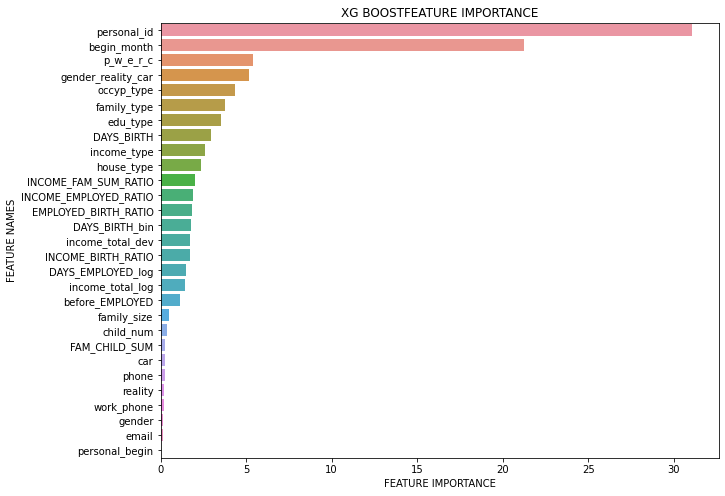

In [19]:
#plot the xgboost result
plot_feature_importance(cat_models[0].get_feature_importance(), train_x.columns,'XG BOOST')

In [20]:
def catboost_eval(
                  depth , 
                  learning_rate ,
                  min_data_in_leaf , 
                  border_count):
    
    train_x = train.drop(['credit'],axis=1)
    train_y = train['credit']
    cat_features = [0,1,2,4,5,6,7,12,15,16,17]
    
    n_splits=5
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    predict = None
    params = {}
    params['n_estimators'] = 500
    params['random_seed'] = 42
    params['learning_rate'] = learning_rate
    params['min_data_in_leaf'] = int(round(min_data_in_leaf))
    params['depth'] = int(round(depth))
    params['border_count'] = int(round(border_count))
    #params['bagging_temperature'] = int(round(bagging_temperature))
    
    outcomes=[]
    
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        
        cat = CatBoostClassifier(**params , langevin=True)
        cat.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              early_stopping_rounds=20, cat_features=cat_features,
              verbose=100)

        predictions = cat.predict_proba(X_val)

        logloss=log_loss(to_categorical(y_val), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        print(f'================================================================================\n\n')
        
    mean_outcome=np.mean(outcomes)
    print("Mean:{}\n\n".format(mean_outcome))
    
    return mean_outcome



In [21]:
# from bayes_opt import BayesianOptimization
# import xgboost as xgb
# import catboost as cat

# catBO = BayesianOptimization(catboost_eval,
#                              {
#                               'depth': (4, 12) ,
#                               "learning_rate" : (0.001,0.2) , 
#                               "min_data_in_leaf" : (1,100) , 
#                               'border_count': (5, 255) ,
#                              },
#                              random_state=0)
# init_round=5
# opt_round = 5
# catBO.maximize(init_points=init_round, n_iter=opt_round)

In [22]:
# params = catBO.max['params']
# params

In [23]:
my_submission

array([[0.12196754, 0.1594927 , 0.71853975],
       [0.33612409, 0.23272579, 0.43115012],
       [0.04623597, 0.07491981, 0.87884423],
       ...,
       [0.04702529, 0.10896778, 0.84400693],
       [0.14463077, 0.31029951, 0.54506972],
       [0.06594854, 0.41659899, 0.51745247]])

In [24]:
submission=pd.read_csv('./open/sample_submission.csv')
submission.loc[:,1:]=my_submission
submission

,index,0,1,2
0,26457,0.121968,0.159493,0.718540
1,26458,0.336124,0.232726,0.431150
2,26459,0.046236,0.074920,0.878844
3,26460,0.062872,0.090487,0.846641
4,26461,0.087363,0.220187,0.692450
...,...,...,...,...
9995,36452,0.077053,0.226405,0.696543
9996,36453,0.134437,0.412814,0.452749
9997,36454,0.047025,0.108968,0.844007
9998,36455,0.144631,0.310300,0.545070


In [25]:
submission.to_csv('./submit/10fold_cat_0.66695.csv', index=False) # 0.7272812144

In [26]:
submission.head(20)

,index,0,1,2
0,26457,0.121968,0.159493,0.718540
1,26458,0.336124,0.232726,0.431150
2,26459,0.046236,0.074920,0.878844
3,26460,0.062872,0.090487,0.846641
4,26461,0.087363,0.220187,0.692450
5,26462,0.055825,0.123023,0.821152
6,26463,0.603421,0.361610,0.034969
7,26464,0.055175,0.096416,0.848409
8,26465,0.066278,0.094999,0.838723
9,26466,0.056543,0.271235,0.672222
